# Deep Learning  第5回

## 今回の目標
前回までで実装したニューラルネットワークに学習機能を追加する

## ニューラルネットワークの学習

### 学習の流れ
- サンプルデータを取る
- 損失を算出する
- 勾配を算出する
- 重みを修正
- 繰り返す



### サンプルデータを取る
#### ミニバッチ
膨大な数のデータを一つずつ処理すると、計算量が増えすぎる。  
この問題を解消するため、データ全体の中からランダムで幾つかのデータを取り出して小さな塊(ミニバッチ)を作成し、データの代表として扱う。    

![ミニバッチ](images/learning/mini_batch.svg)

### 損失を算出する
#### 損失関数
ニューラルネットワークが出した結果と実際の正解を比較して、どれだけ精度が悪かったかを出す。  
悪さの指標のため、これが0に近づくようにニューラルネットワークに学習を行わせると正答率が上がる。

##### 正答率でなく損失を使う理由
正答率は変化が段階的。  
一方、損失は重みを微小に変更するだけで連続的に値が変化する。  
その為以下で説明する勾配法が使える。

##### 交差エントロピー誤差

$$E=-\sum _{ k }^{  }{ { t }_{ k }\log { { y }_{ k } }  } $$

${y}_{k}$ はニューラルネットワークの出力  
${ t }_{ k }$ は正解ラベル、正解の時だけ 1 で他は 0


元コード：
https://github.com/oreilly-japan/deep-learning-from-scratch

In [8]:
import numpy as np
import matplotlib.pyplot as plt

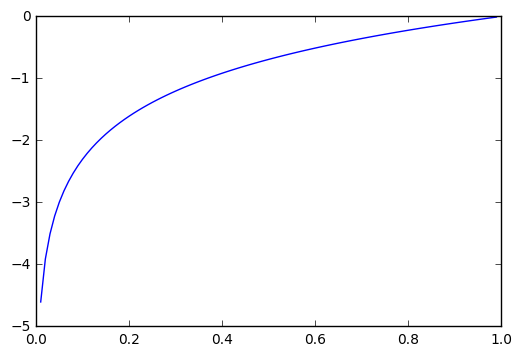

In [9]:
x = np.arange(0.01,1,0.01)
y = np.log(x)

plt.plot(x,y)
plt.show()

In [10]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

In [6]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # 正解は 2
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]  # ニューラルネットワークは 2 を選択(0.6)
cross_entropy_error(np.array(y), np.array(t))

0.51082562376599072

In [7]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0] # ニューラルネットワークは 7 を選択(0.6)
cross_entropy_error(np.array(y), np.array(t))

2.3025850929940455

### 勾配を算出する

重みの変更によって、損失がどれだけ変わるかが勾配である。  
正答率を上げるには勾配が小さくなる方向に重みを設定し直せばよい。

#### 損失を重みで微分し勾配を出す



$$W=\begin{pmatrix} { w }_{ 11 } & { w }_{ 21 } & { w }_{ 31 } \\ { w }_{ 12 } & { w }_{ 22 } & { w }_{ 32 } \end{pmatrix}$$

$$\frac { \partial L }{ \partial W } =\begin{pmatrix} \cfrac { \partial L }{ { \partial w }_{ 11 } }  & \cfrac { \partial L }{ { \partial w }_{ 21 } }  & \cfrac { \partial L }{ { \partial w }_{ 31 } }  \\ \cfrac { \partial L }{ { \partial w }_{ 12 } }  & \cfrac { \partial L }{ { \partial w }_{ 22 } }  & \cfrac { \partial L }{ { \partial w }_{ 32 } }  \end{pmatrix}$$

In [11]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

### 重みを修正

#### 学習率
一回の学習でどれだけパラメータを変化させるか。  
人間の手で決めてやる必要がある。  
大きすぎると値が収束しない。小さすぎると学習が進まない。

### 繰り返す
以上の流れを繰り返すと損失が0付近に収束し、学習が深まる。はず。

## 二層ニューラルネットワークの実装

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [15]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

In [16]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 3001  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1 # 学習率

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1) # 60000 / 100 = 600 = 1 epoch

for i in range(iters_num):
    print("start: " + str(i))
    
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    grad = network.numerical_gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    print("end: " + str(i))
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

start: 0
end: 0
train acc, test acc | 0.0975166666667, 0.0974
start: 1


##### グラフ描画

In [ ]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()